# Overview of Audio, Spectrogram, & AudioMoth modules

In this example, we'll demonstrate how audio files can be loaded, processed, and visualized using OpenSoundscape.
Let's start with setting up the files we'll be working with and loading the modules we want from OpenSoundscape.

Here, we'll use two AudioMoth recordings as examples: one of several Winter Wren songs and another of a Northern Parula call. Both recordings were collected by the Kitzes Lab in one of our field deployments.

In [1]:
# Import the relevant & helper modules.
from opensoundscape import Audio, Spectrogram
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'

#### Load an audio file containing a winter wren song


In [2]:
resource_path = './resources/01/'
audio_path = resource_path+'winterWren.WAV'

In [3]:
# Here, we load in the audio from a given file location.
audio = Audio.from_file(audio_path)
# Print our sound's duration and sample rate from the Audio object.
print(f"Audio is {audio.duration} seconds long and has a sample rate of {audio.sample_rate} Hz.")

Audio is 60.0 seconds long and has a sample rate of 32000 Hz.


### View metadata
This audio file was recorded by an AudioMoth. OpenSoundscape automatically parses metadata from AudioMoth recordings, and stores them in the audio object's `.metadata` dictionary. This includes information such as temperature, device ID, start time of recording, and gain setting as separate fields.

Let's look at a few of the metadata values:

In [4]:
print(f"recording start time: {audio.metadata['recording_start_time']}")
print(f"device ID: {audio.metadata['device_id']}")
print(f"temperature at start of recording: {audio.metadata['temperature_C']} C")
print(f"battery voltage: {audio.metadata['battery_state']} V")

recording start time: 2021-06-24 10:32:00+00:00
device ID: AudioMoth 240435085A34AA85
temperature at start of recording: 13.9 C
battery voltage: 4.0 V


## Spectrograms

Now, let's visualize our sound as a spectrogram using OpenSoundscape's Spectrogram module. A spectrogram is a 2-dimensional representation of sound with time on the x-axis and frequency on the y-axis. 

/Users/jk/opt/anaconda3/envs/opso/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


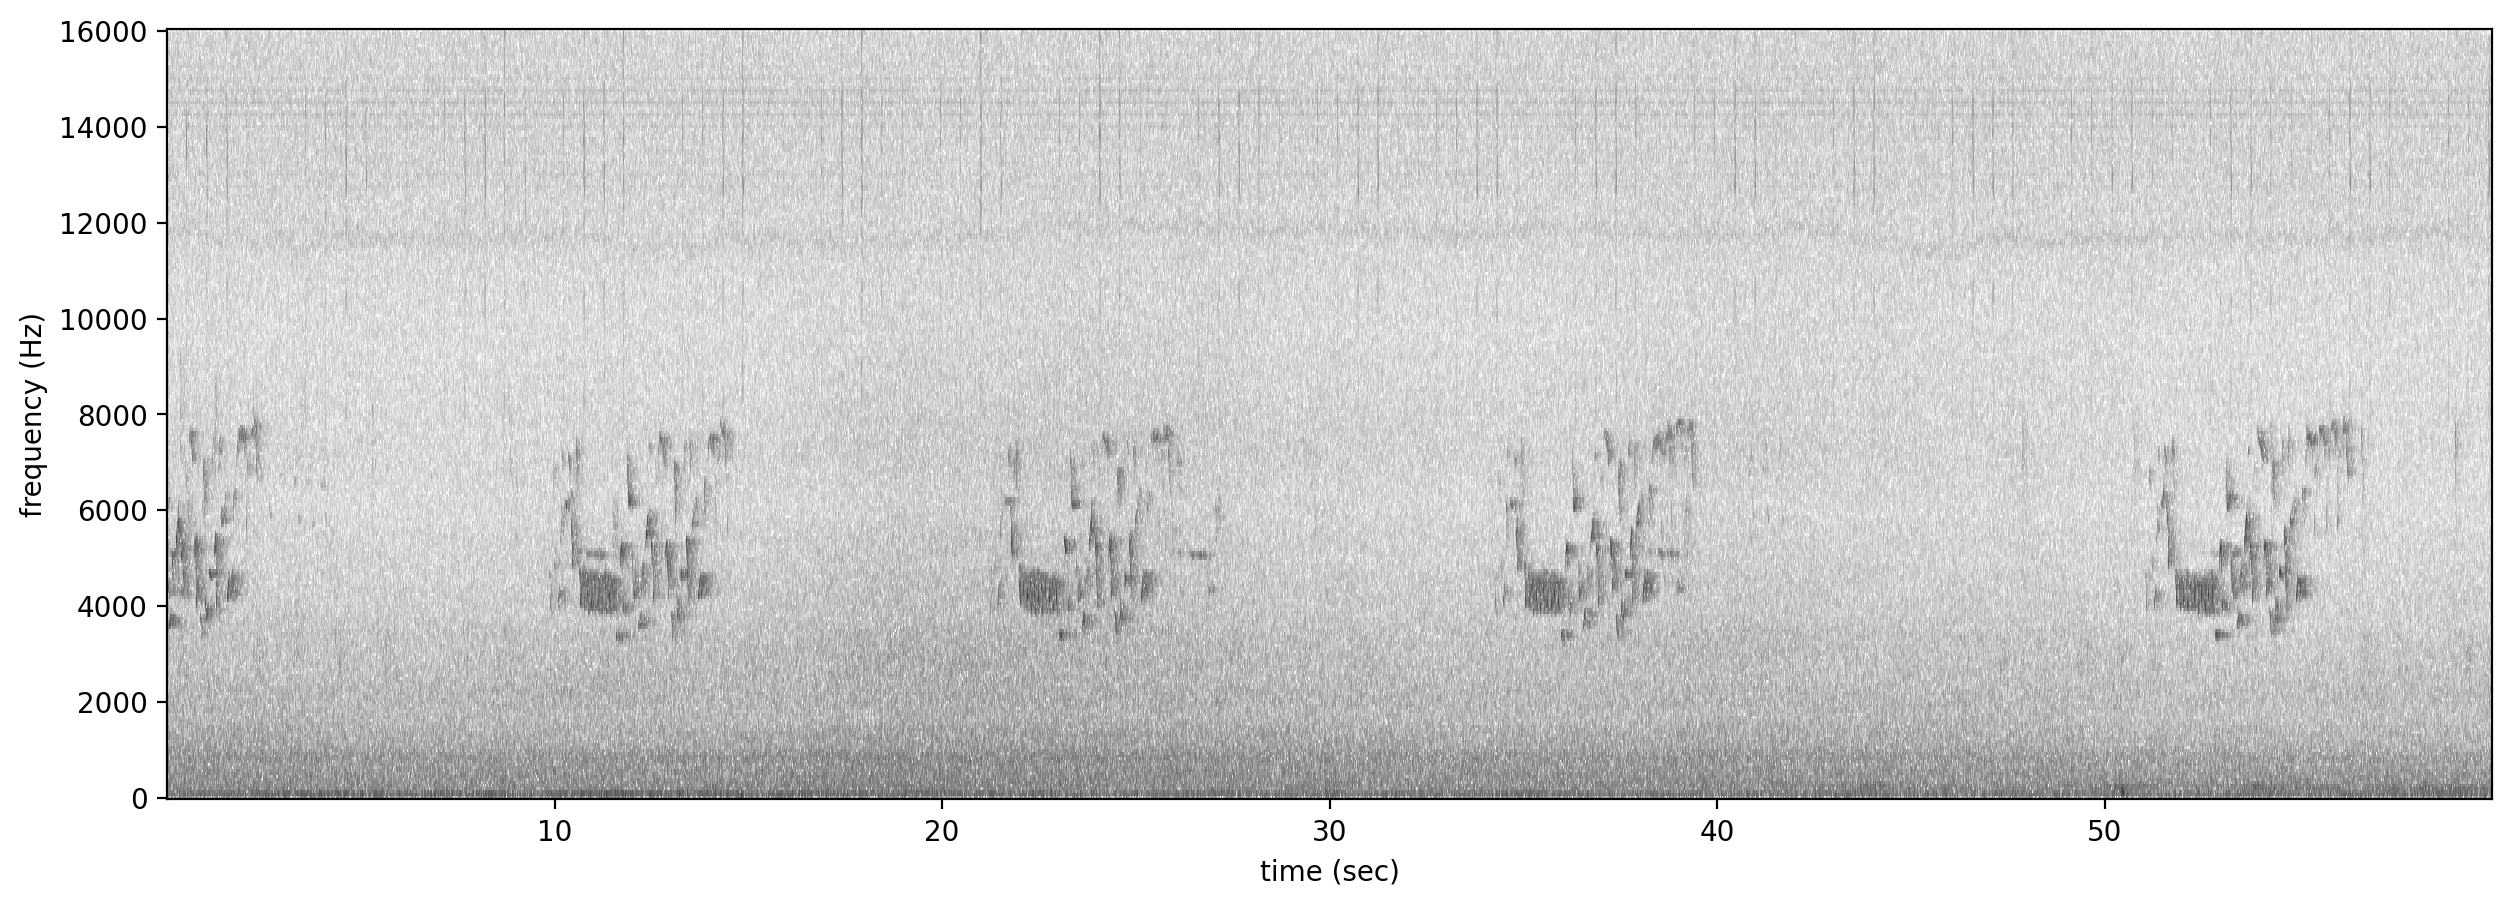

In [5]:
# Create spectrogram object from our previously loaded audio object and view it. 
spec = Spectrogram.from_audio(audio)

# Show the spectrogram as an image
spec.plot()

### trim and bandpass

Though we can see the whole soundscape visualized above, this spectrogram doesn't tell us much about the Winter Wren call that we want to investigate. Let's trim and bandpass the spectrogram to the region of the first song: 10-15 seconds, and 3000-8000 Hz. 

In [6]:
# Get the desired segment of audio.
trimmed_audio = audio.trim(50, 57)

# Print new duration and sample rate.
print(f"trimmed_audio is {trimmed_audio.duration} seconds long.")

trimmed_audio is 7.0 seconds long.


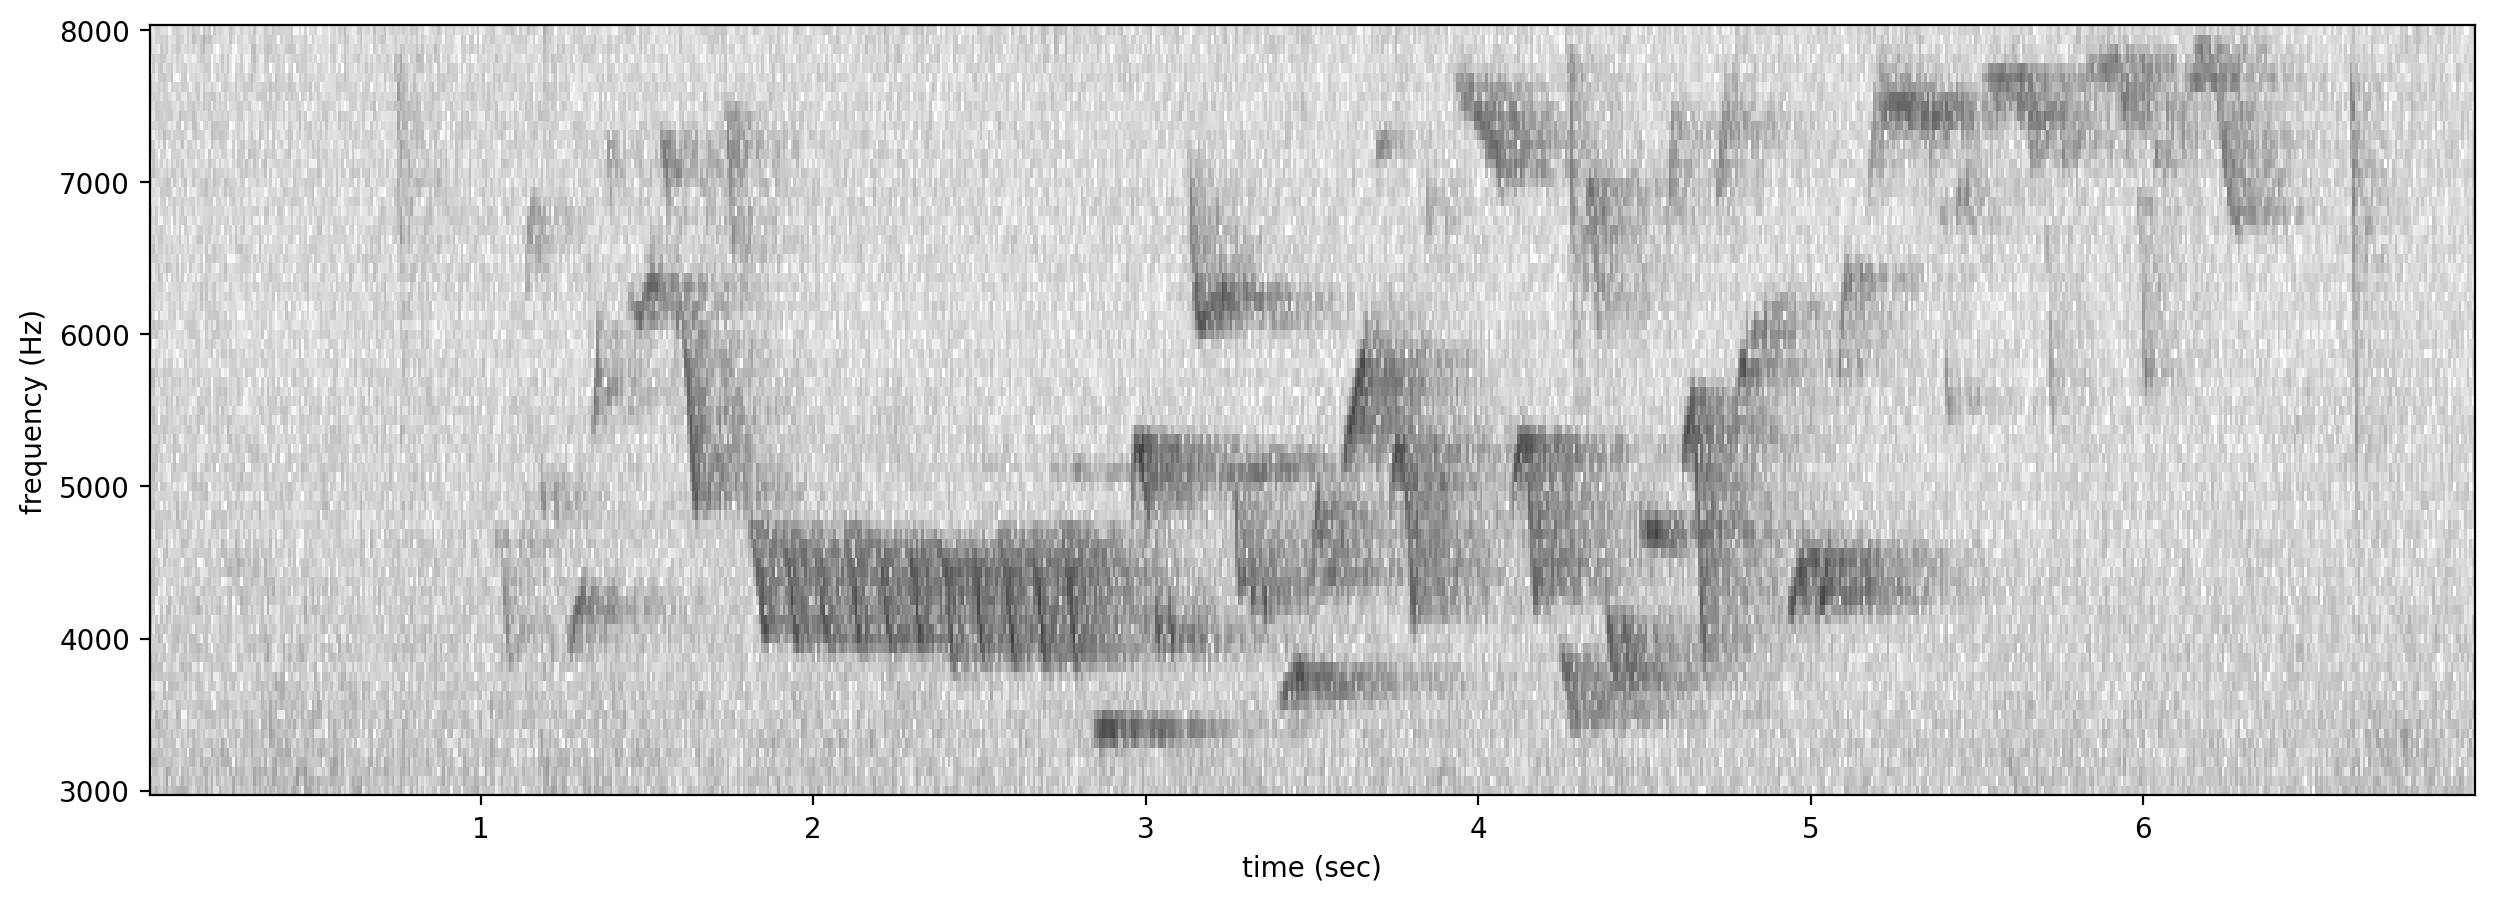

In [7]:
# Create spectrogram object from our previously loaded, trimmed audio object and view it. 
spec = Spectrogram.from_audio(trimmed_audio)

# bandpass the spectrogram to 3000-8000 Hz
spec = spec.bandpass(3000,8000)

# show spectrogram as image
spec.plot()

### adjust spectrogram parameters
The syllables of the winter wren are looking fuzy here. To improve the frequency resolution of the spectrogram, let's try modifying the spectrogram generation parameters. We'll change the window size from the default of 512 to 1024 (increases frequency resolution at the cost of time resolution), and increase window overlap fraction to 0.8 to improve temporal resolution. 

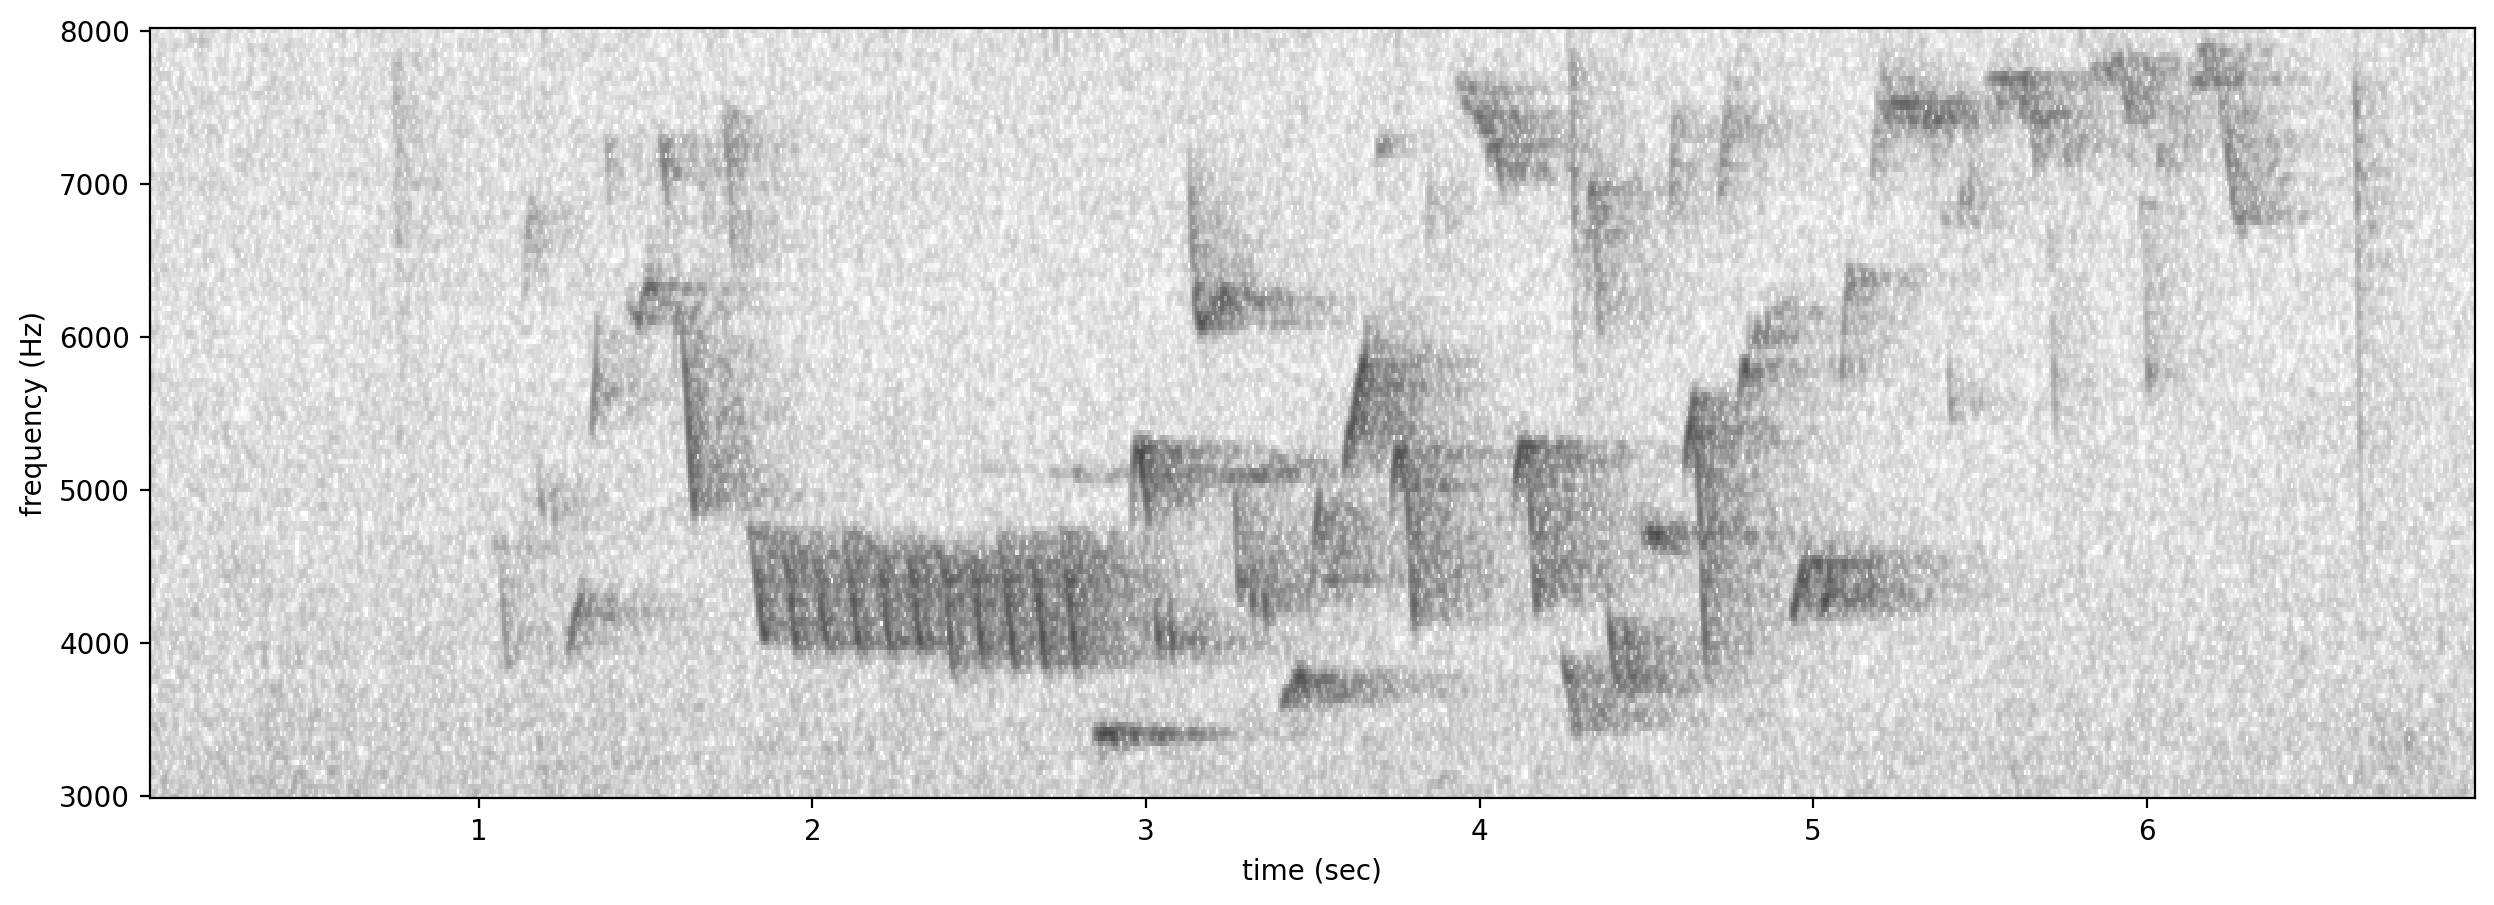

In [8]:
# Create spectrogram object from our previously loaded, trimmed audio object and view it. 
spec = Spectrogram.from_audio(trimmed_audio,window_samples=1024,overlap_fraction=0.8)

# bandpass and plot
spec.bandpass(3000,8000).plot()

## Saving audio files

Audio objects can be saved to various audio file formats such as WAV (uncompressed) and mp3 (compressed, lossy).

Changes to the Audio object's metadata are also retained when audio files are saved. 

In [9]:
# modify the temperature saved in the metadata
trimmed_audio.metadata['temperature_C']=-5 

# save the audio file
file_path = resource_path+'wiwr_7sec_call.WAV'
trimmed_audio.save(file_path)

# reload and check the metadata temperature
print(f"saved file's temperature field: {Audio.from_file(file_path).metadata['temperature_C']} C")

saved file's temperature field: -5 C


## Load region of audio file

We can load a specific region of a WAV file without loading the entire file. This is extremely fast when we just want, for example, a few seconds from a recording that is hours long. 

Let's load 7 seconds of the audio file (duration=7) starting 50 seconds into the recording (offset=50)

Here, we also demonstrate that Audio.from_file can resample the audio to a new sampling rate.

In [10]:
# Load the region of an Audio file from 50-57 seconds, and resample to 22050 Hz
audio_segment = Audio.from_file(audio_path, offset = 50, duration = 7, sample_rate=22050)
print(f"duration of loaded audio: {audio_segment.duration} seconds. Sample rate: {audio_segment.sample_rate}.")

duration of loaded audio: 7.0 seconds. Sample rate: 22050.


### Load audio from specific date and time
Some audio files (including those recorded by AudioMoths) contain metadata indicating the start date and time of the audio recording. We can easily load a segment of audio starting at a specific date and time:

In [11]:
# specify the desired date and time of the Audio to load
from datetime import datetime
import pytz
local_timezone = pytz.timezone('US/Eastern')
desired_start = local_timezone.localize(datetime(2021, 6, 24, 6, 32,30))

Load 10 seconds of audio starting at 6:32:30 AM Eastern time on June 24, 2021

In [12]:
# load the audio at a specific time
segment = Audio.from_file(audio_path,start_timestamp=desired_start,duration=10)

# print the start time
print(f"segment start timestamp: {segment.metadata['recording_start_time'].astimezone(local_timezone).isoformat()}")

segment start timestamp: 2021-06-24T06:32:30-04:00


## Split audio into clips

When preparing audio for analysis or in situations where a file is too large to process entirely, OpSo's Audio module contains functions used to split audio and optionally save the resulting clips as new files.

In [13]:
# Using split_and_save to 'save' clips to a hypothetical location.
# The dry_run tag, when set to True, will set the function to return the resulting DataFrame without actually saving the clips.
# The -4 overlap means a 4-second _gap_ is left between clips!
# Setting final_clip to 'remainder' means saving the shorter last clip and counting it in the DataFrame.
# Other options for final_clip include 'full' (backtrack to increase overlap and get full length) 
# and 'extend' (add silence to get full length)
clip_df = audio.split_and_save(
    destination = resource_path+'tutorial_audio',
    prefix = 'tutorial_clip',
    clip_duration = 10,
    clip_overlap = -4,
    final_clip = 'remainder',
    dry_run = True
)
clip_df

start_time  end_time
file                                                                    
./resources/01/tutorial_audio/tutorial_clip_0.0...         0.0      10.0
./resources/01/tutorial_audio/tutorial_clip_14....        14.0      24.0
./resources/01/tutorial_audio/tutorial_clip_28....        28.0      38.0
./resources/01/tutorial_audio/tutorial_clip_42....        42.0      52.0
./resources/01/tutorial_audio/tutorial_clip_56....        56.0      60.0

## Modifying `Audio` objects

In addition to splitting Audio objects, we are able to extend and loop them to change their duration. For this example, let's increase the length of our Winter Wren call audio by adding silence and then looping it

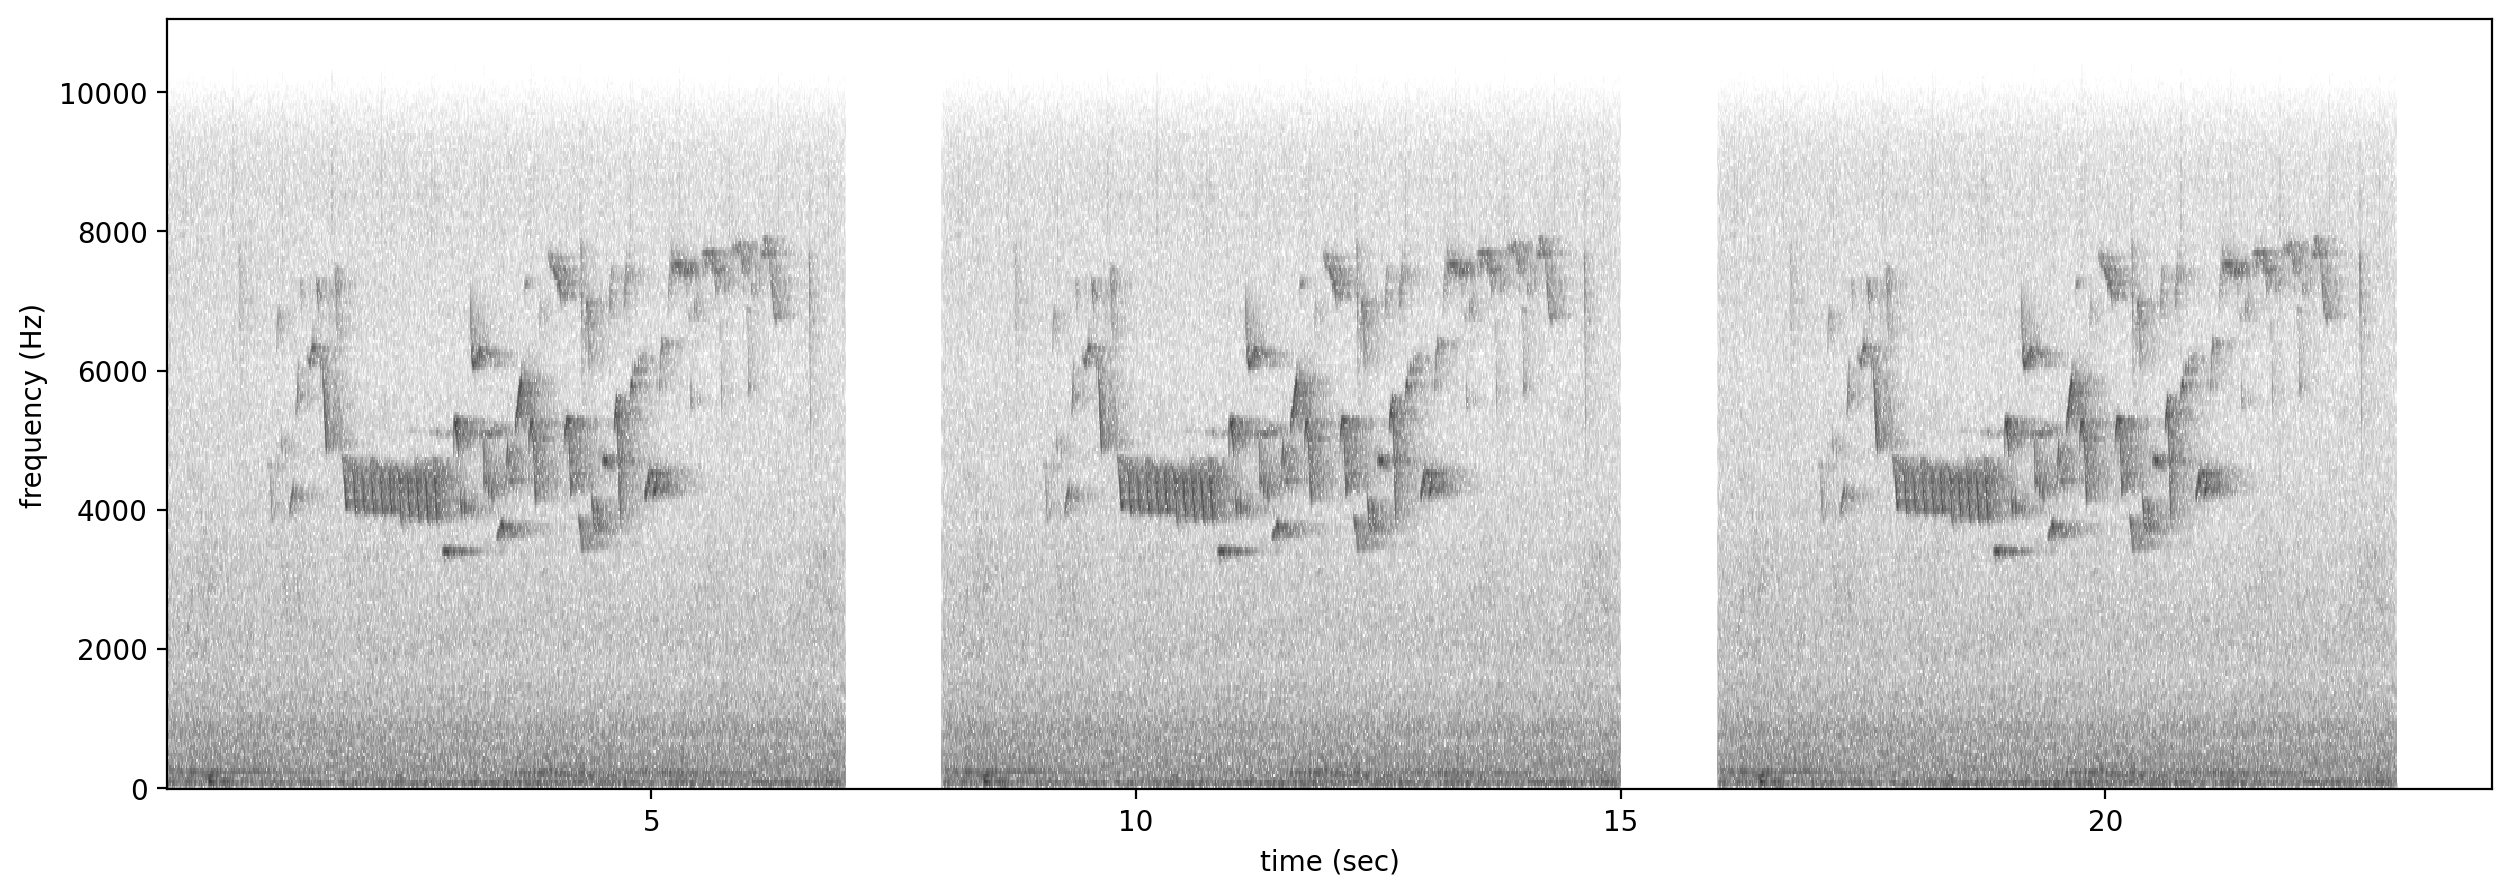

In [14]:
# Extend audio to desired length, adding silence 
extended_audio = audio_segment.extend(audio_segment.duration + 1)
# Loop the audio 3 times
looped_audio = extended_audio.loop(n=3)
# plot
Spectrogram.from_audio(looped_audio).plot()

# Manipulating a northern parula call

Now that we know a few simple commands for manipulating audio and reading its metadata, we'll take a look at other sound properties that can be viewed and edited with OpenSoundscape. For the second part of this tutorial, we'll use the Northern Parula recording mentioned in the beginning.

Let's see the song's spectrogram and view some other changes we can make to spectrogram and audio with OpenSoundscape - like changing frequency and sound intensity ranges!

In [15]:
# create Audio from file path
file_path = resource_path+'parula_2sec_call.WAV'
audio = Audio.from_file(file_path)

When creating a Spectrogram, we can adjust the sound level range by using the decibel_limits parameter, which determines the minimum and maximum "loudness" level (by default -100 and -20).

Default settings: -100 to -20 dB


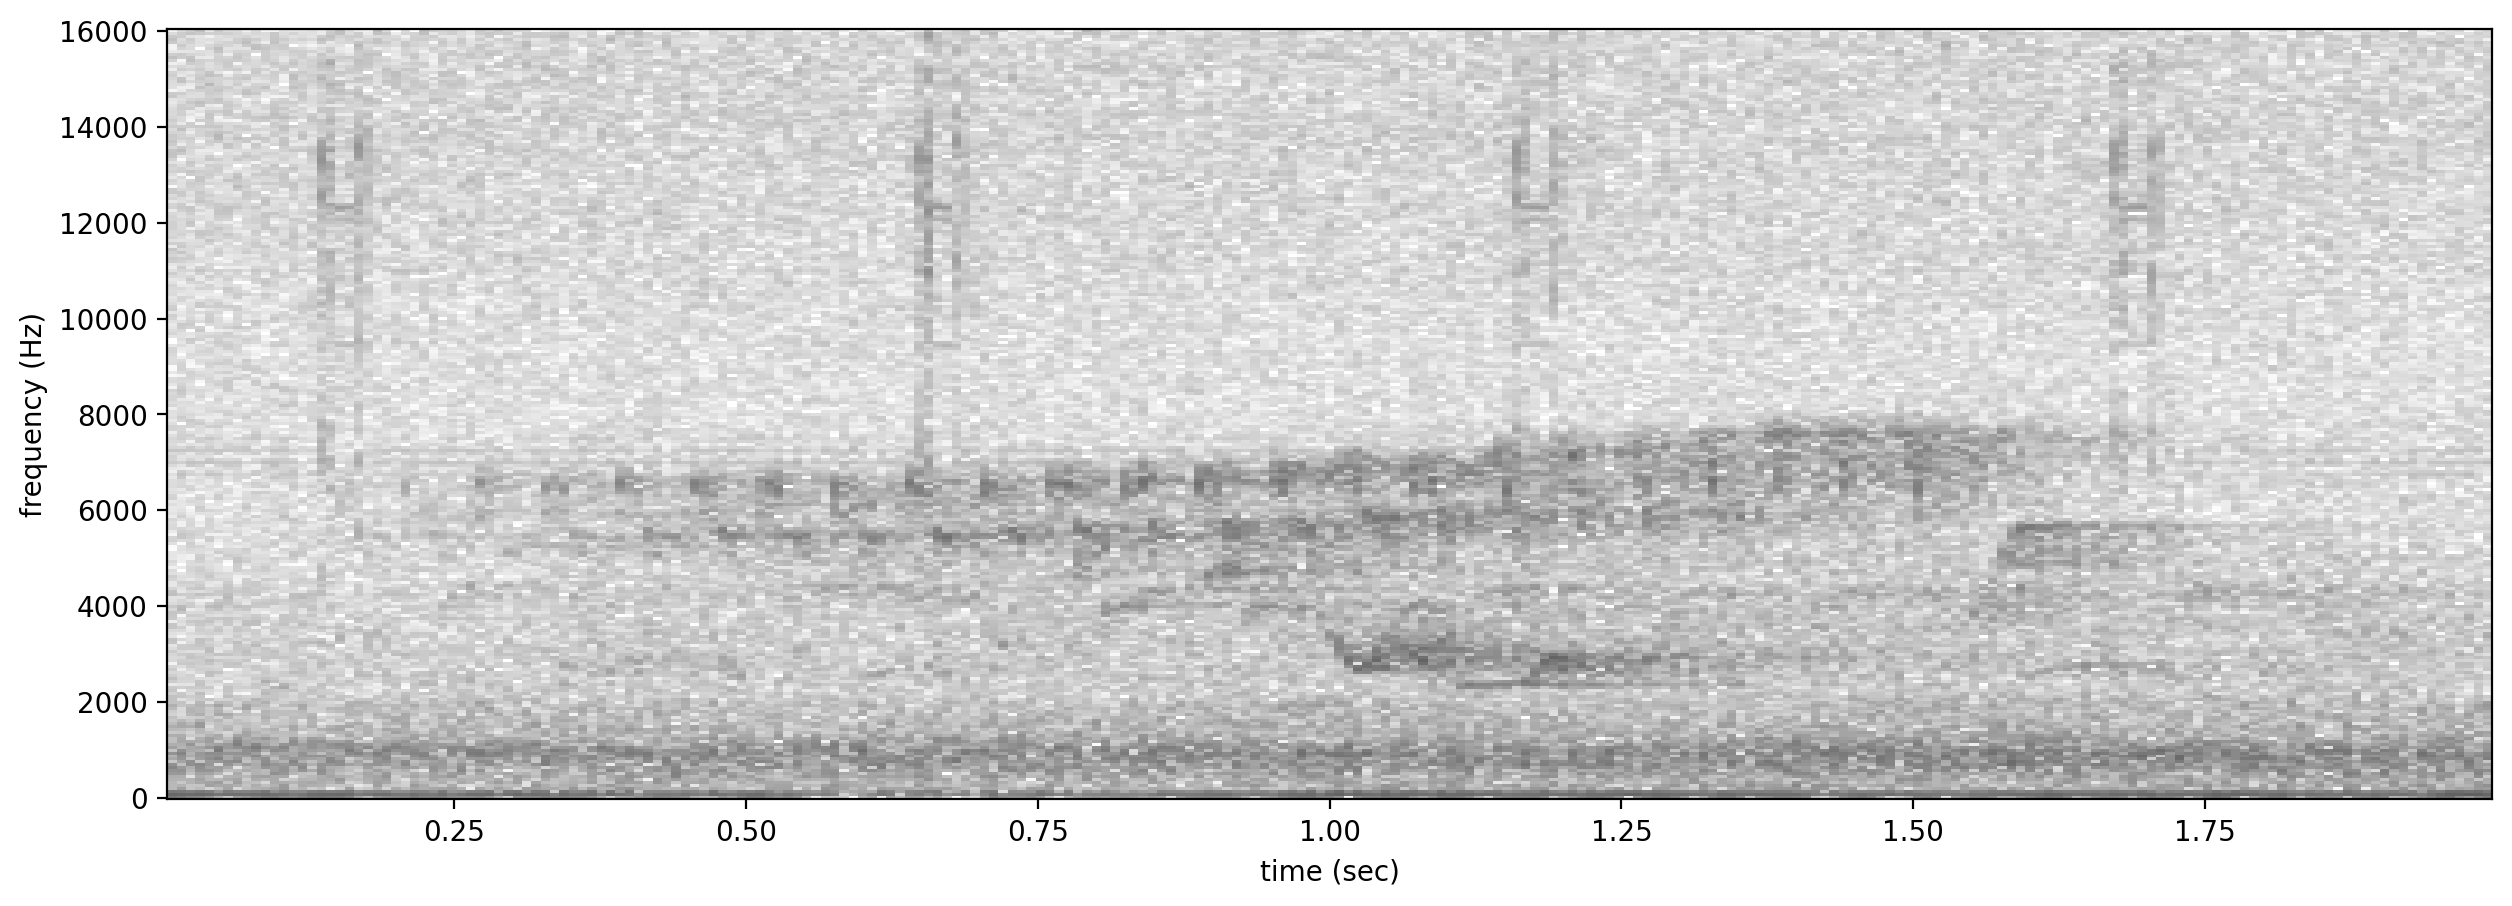

Restricted decibel range: -80 to -30 dB


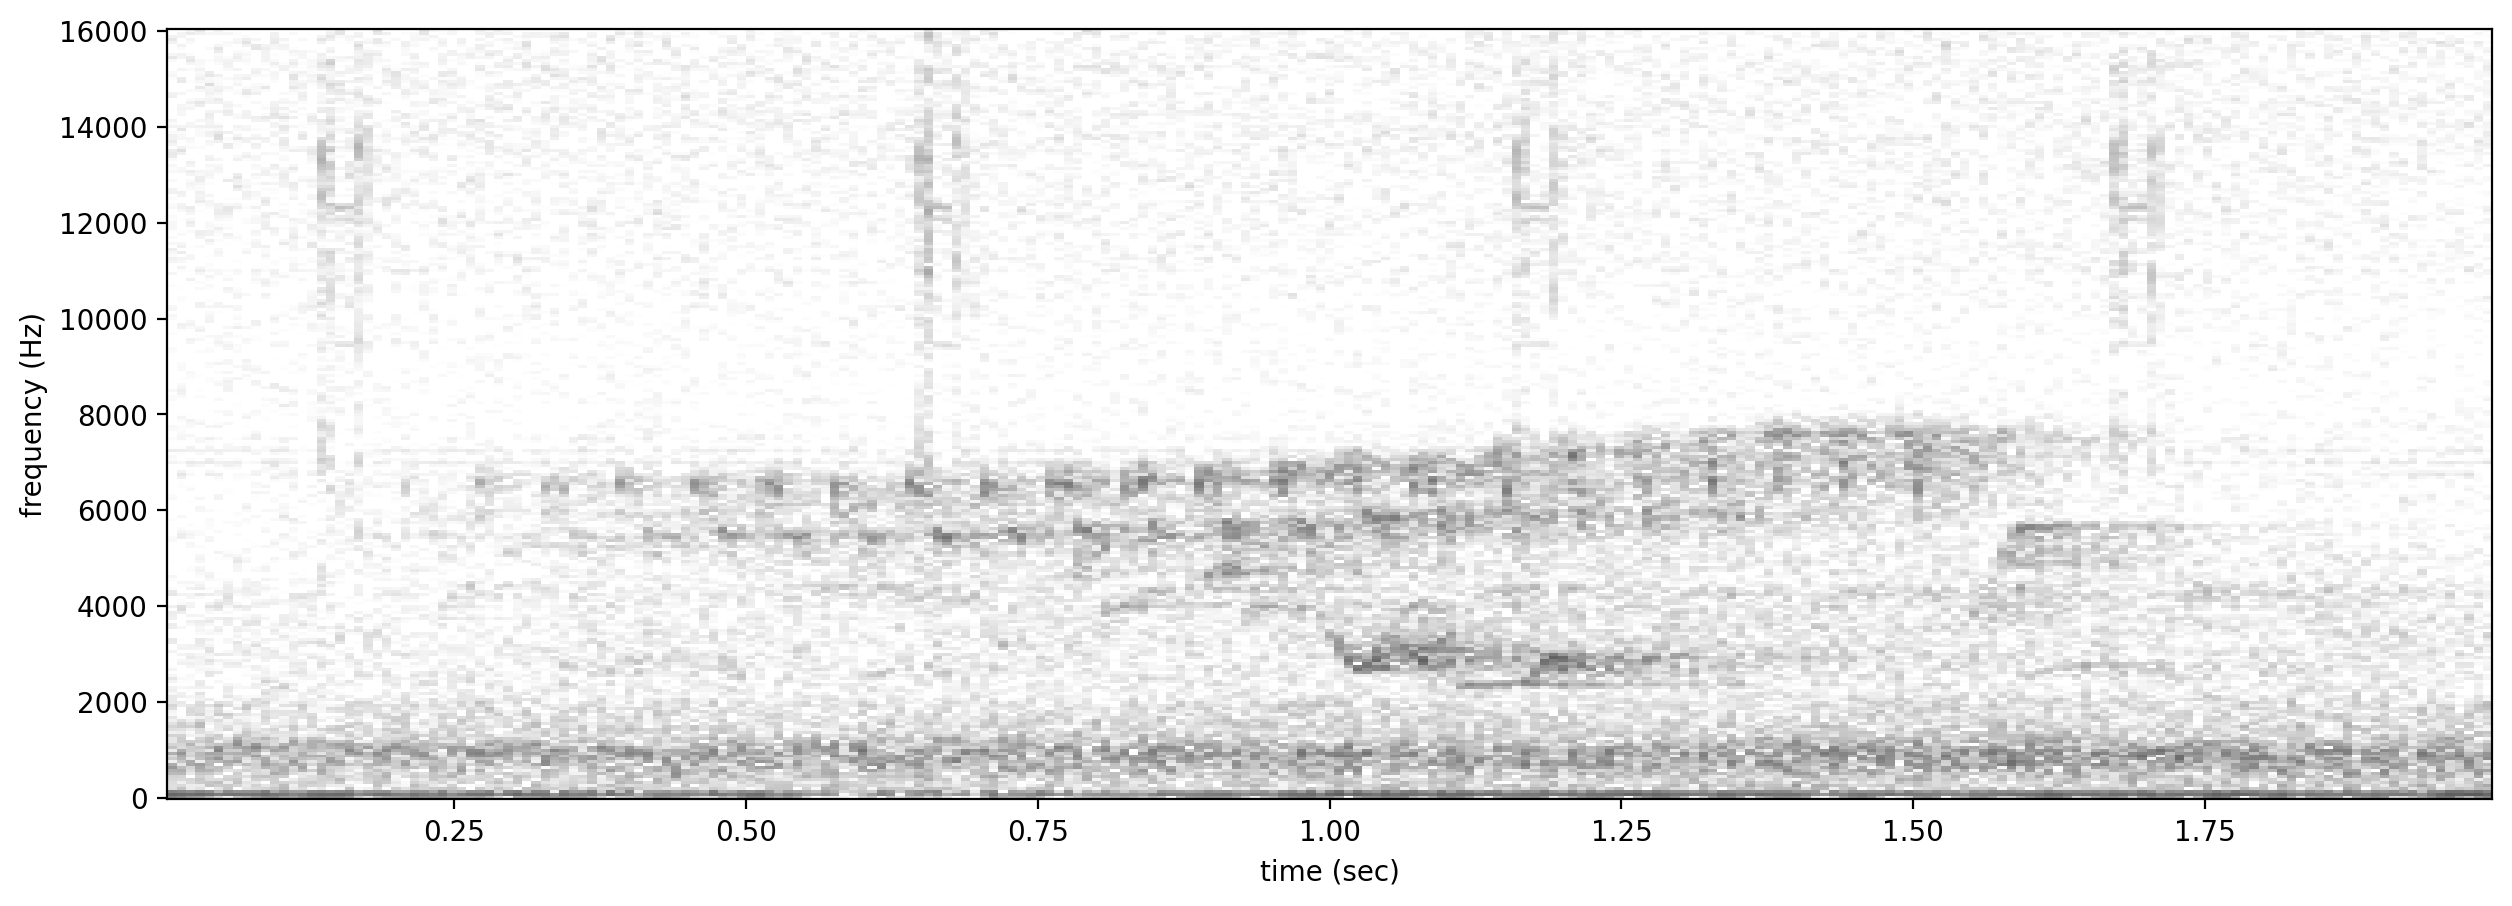

In [16]:
print('Default settings: -100 to -20 dB')
spec = Spectrogram.from_audio(audio)
spec.plot()
print('Restricted decibel range: -80 to -30 dB')
Spectrogram.from_audio(audio, decibel_limits = (-80, -30)).plot()

We can easily save the spectrogram as an image:

In [17]:
# Convert our spectrogram to an Image object and save it!
spec.to_image().save(resource_path+'example_1.png')

## Bandpassing and frequency spectrum 

Let's apply a bandpass filter to the Audio object to excludes noises occurring outside of the Northern Parula's frequency range. 

Plotting a spectrogram of the modified Audio object shows the effect of the bandpass filter

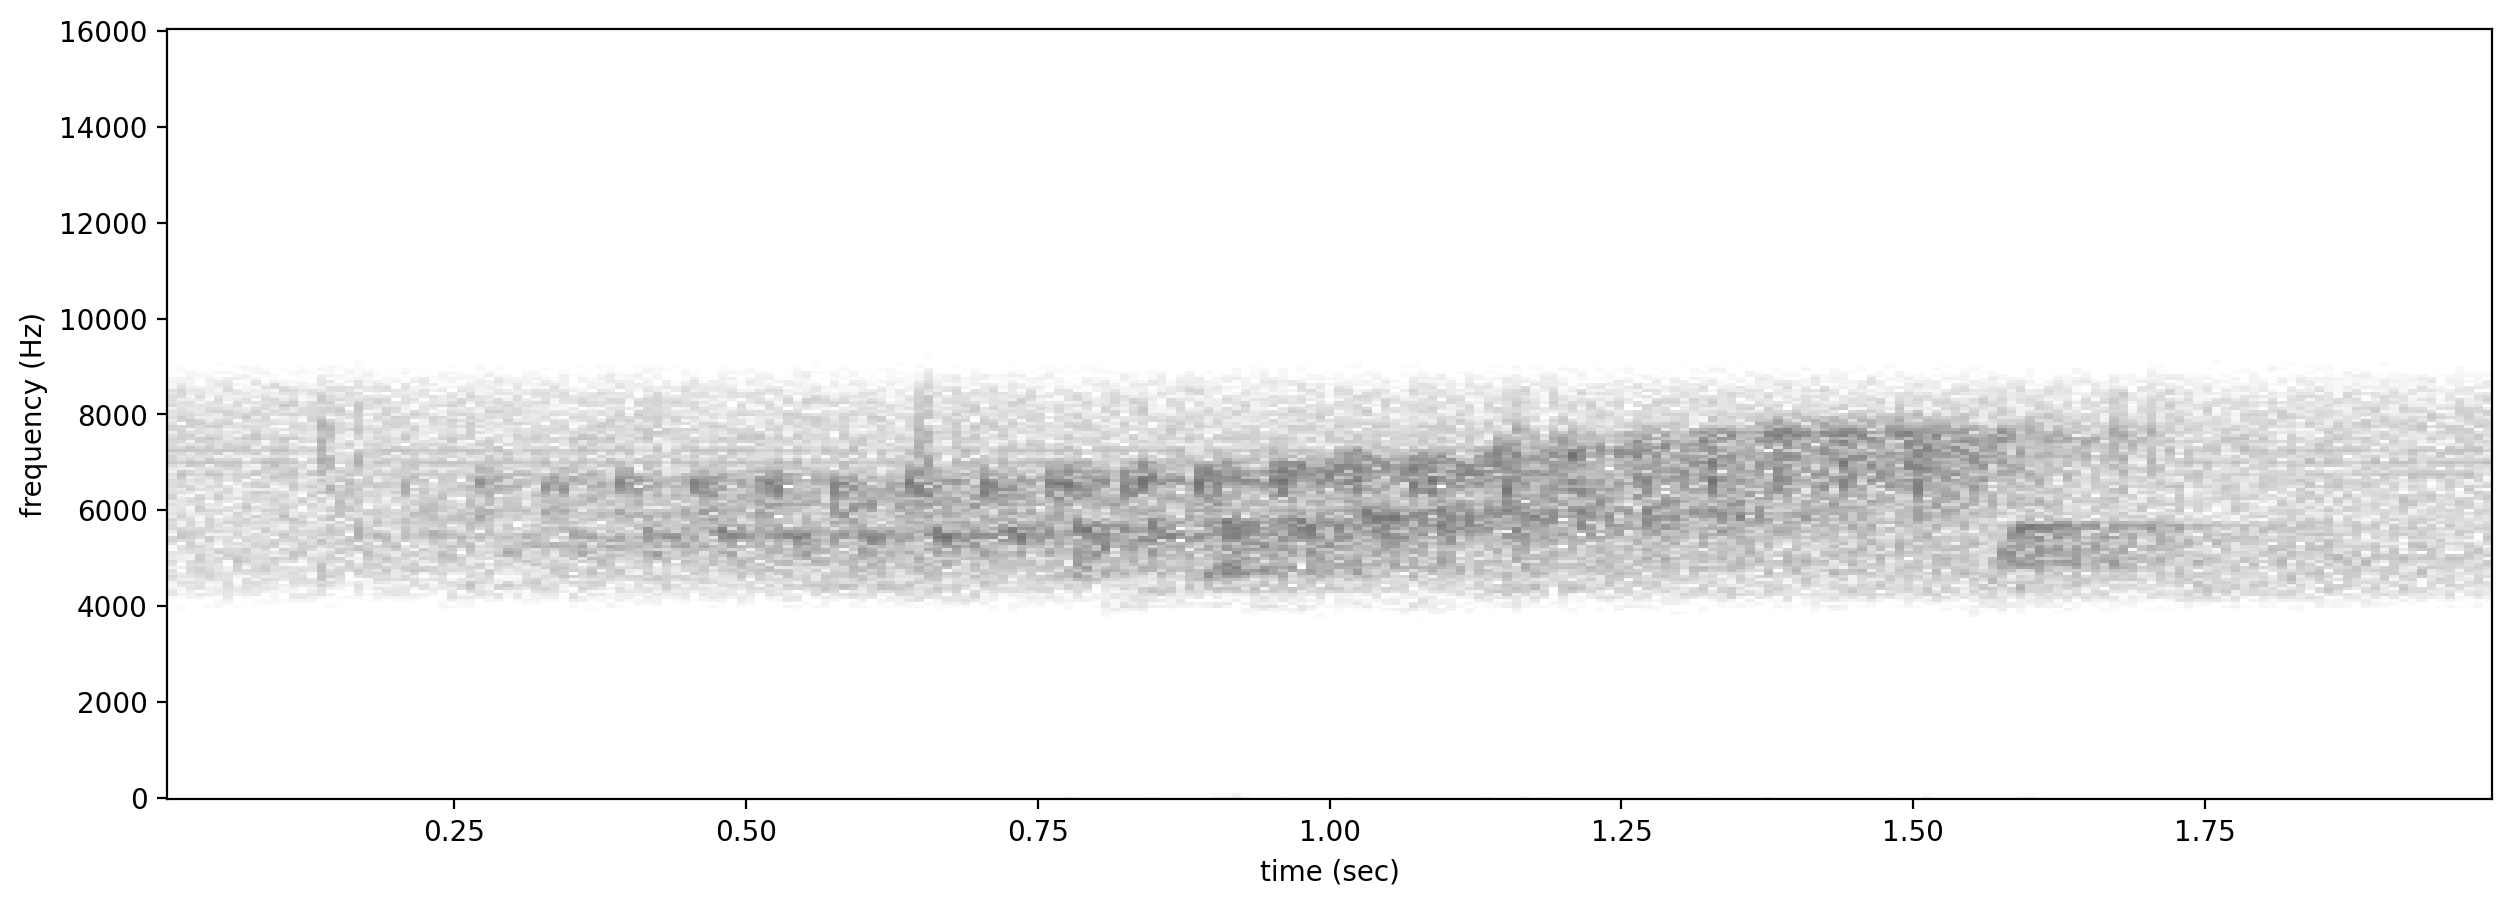

In [18]:
bandpassed_audio = audio.bandpass(low_f = 4500, high_f = 8500, order = 5)
spec = Spectrogram.from_audio(bandpassed_audio)
spec.plot()

we can also calculate the frequency spectrum for an entire audio object. Let's compare the frequency spectrum of the original and bandpassed audio:

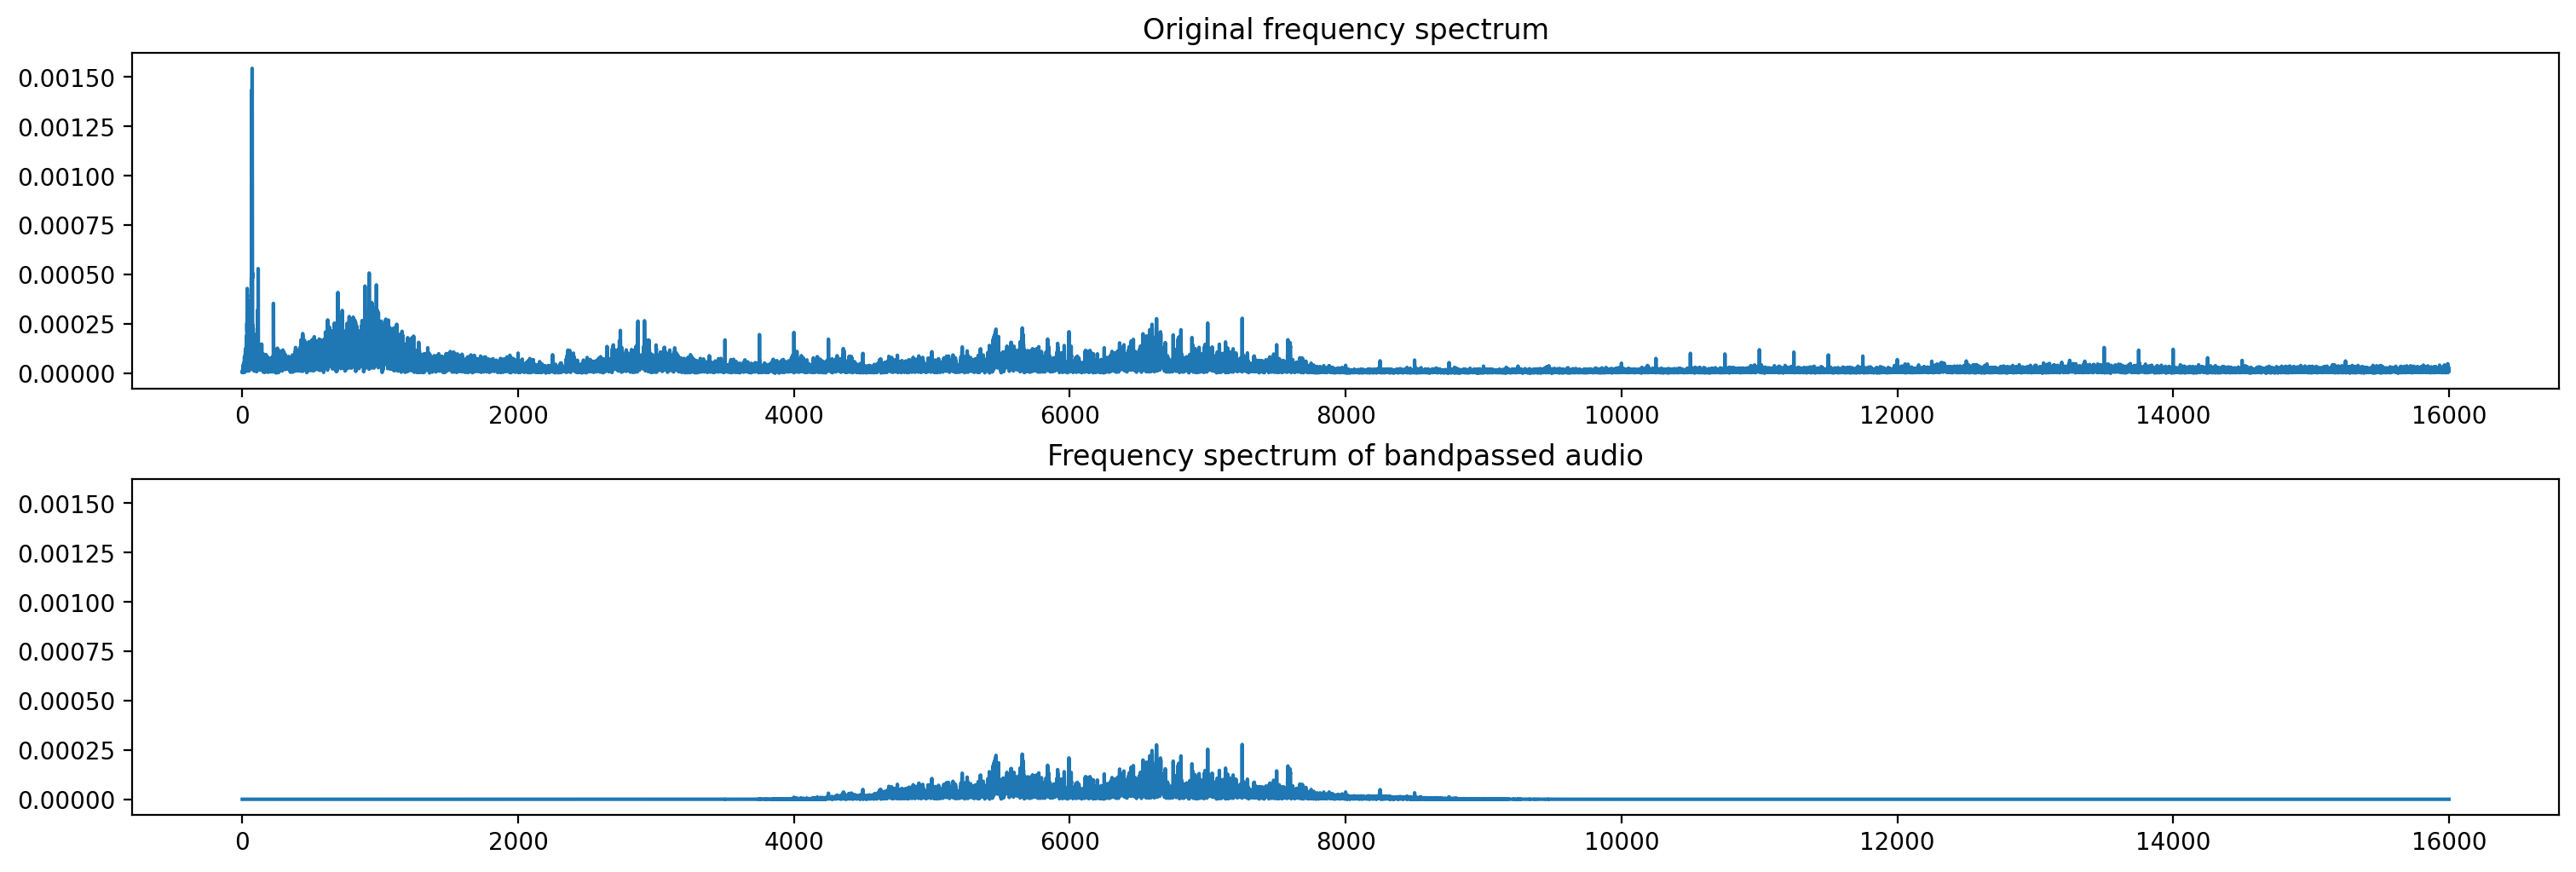

In [19]:
# Visualize the frequency spectrum for original and bandpassed audio.
fig, ax = plt.subplots(2, sharey = True, constrained_layout = True)
ax[0].plot(audio.spectrum()[1], audio.spectrum()[0])
ax[0].set_title('Original frequency spectrum')
ax[1].plot(bandpassed_audio.spectrum()[1], bandpassed_audio.spectrum()[0])
ax[1].set_title('Frequency spectrum of bandpassed audio')
plt.show()

## Normalization, gain adjustment, and level measurement

Audio objects give us two ways to modify the overal level of the signal: (1) applying gain, which changes the level of the signal by a fixed amount, or (2) normalizing, which scales the signal to achieve a specified peak value. 

The Audio object's `.rms` and `.dBFS` properties provide measurements of the signals "root mean square" and "decibels Full Scale" values. 

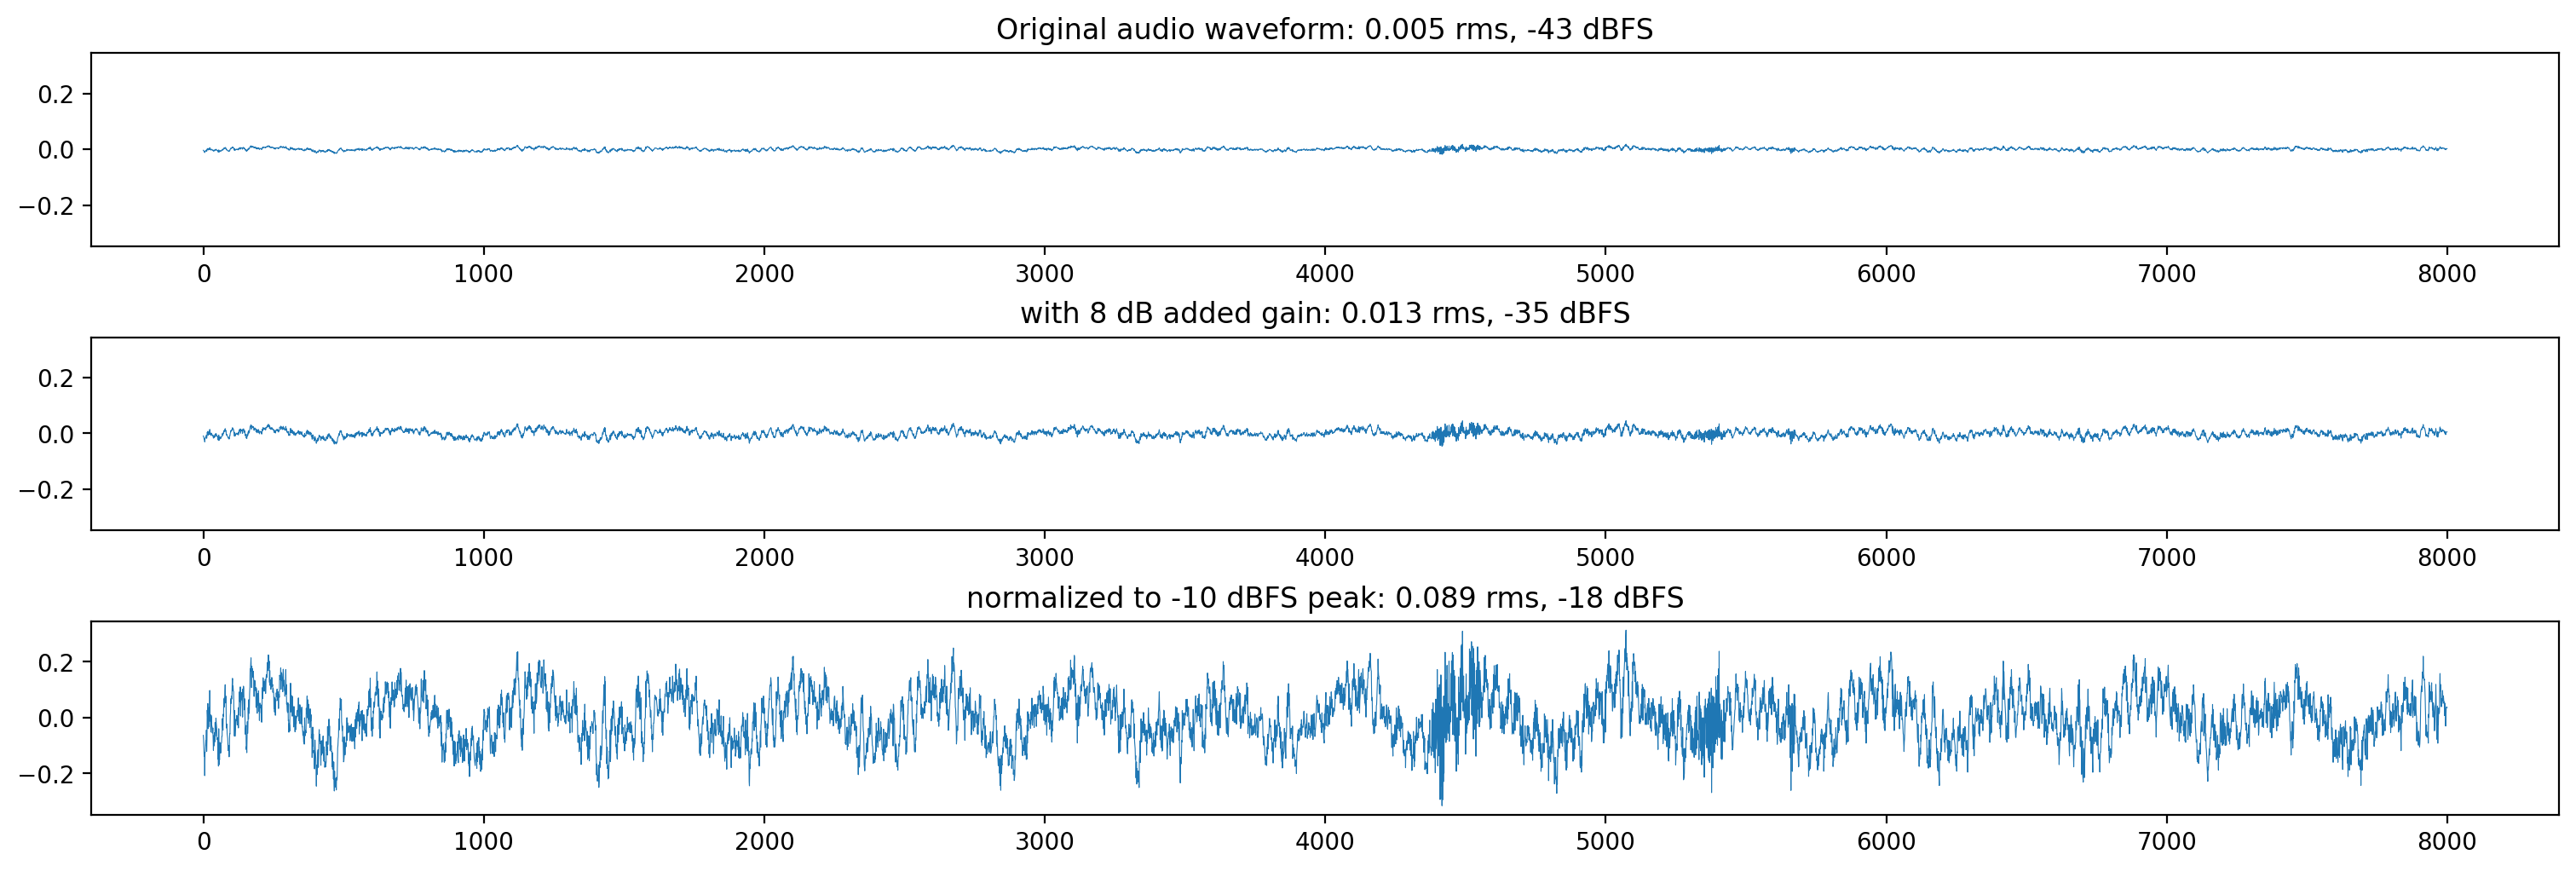

In [20]:
# get a short segment of the audio
clip = audio.trim(0,.25)

# Now let's adjust the audio parameters! Normalize the loaded audio file to even out its volume.
normalized = clip.normalize(peak_dBFS=-10)

# Add 8 dB of gain to the audio
with_gain = clip.apply_gain(dB = +8)

# Plot audio waveforms
fig, ax = plt.subplots(3, sharey=True, constrained_layout = True)
ax[0].plot(clip.samples, linewidth = 0.4)
ax[0].set_title(f'Original audio waveform: {clip.rms:0.3f} rms, {clip.dBFS:0.0f} dBFS')
ax[1].plot(with_gain.samples, linewidth = 0.4)
ax[1].set_title(f'with 8 dB added gain: {with_gain.rms:0.3f} rms, {with_gain.dBFS:0.0f} dBFS')
ax[2].plot(normalized.samples, linewidth = 0.4)
ax[2].set_title(f'normalized to -10 dBFS peak: {normalized.rms:0.3f} rms, {normalized.dBFS:0.0f} dBFS')
plt.show()

For full documentation of the [Audio]() and [Spectrogram]() classes, visit [opensoundscape.org](http://opensoundscape.org/en/latest/)